In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from pathlib import Path

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5))]
)

DATA_PATH = Path('/home/commaai-03/Data/dataset/torch/')

# datasets
trainset = torchvision.datasets.FashionMNIST(DATA_PATH,
        download=True,
        train=True,
        transform=transform)

testset = torchvision.datasets.FashionMNIST(DATA_PATH,
                                           download=True,
                                           train=False,
                                           transform=transform)

# dataloader
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=2)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4,
                                         shuffle=False,
                                         num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image.
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap='Greys')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [2]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # in, out, kernel_size, stride, padding
        self.pool = nn.MaxPool2d(2, 2) # kernel_size, stride, padding
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # N = (N - K + 2P) / S + 1
        # in: [4, 1, 28, 28]
        # conv1: [4, 6, 24, 24]
        # pool1: [4, 6, 12, 12]
        x = self.pool(F.relu(self.conv1(x)))
        # conv2: [4, 16, 8, 8]
        # pool2: [4, 16, 4, 4]
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

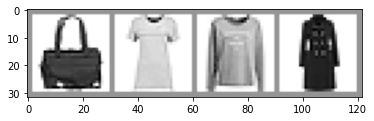

In [4]:
# 1. Tensorboard setup
from torch.utils.tensorboard import SummaryWriter

logdir = '/home/commaai-03/Data/dataset/torch/FashionMNIST/runs'
writer = SummaryWriter(logdir)

# 2. Writing to TensorBoard
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)
# write to tensorboard
writer.add_image('Four_Fashion_Mnist_Images', img_grid)

In [5]:
# 3. Inspect the model using TensorBoard
writer.add_graph(net, images)
writer.close()

In [6]:
# 4. Adding a 'Projector' to TensorBoard
def select_n_random(data, labels, n=100):
    '''
    Select n random datapoints and their corresponding labels from a dataset.
    '''
    
    assert len(data) == len(labels)
    
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28*28)
writer.add_embedding(features, metadata=class_labels,
                     label_img=images.unsqueeze(1))
writer.close()

In [8]:
# 5. Tracking model training with TensorBoard
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities
    from a trained network and a list of images.
    '''
    output = net(images)
    # convert ouput probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    preds, probs = images_to_probs(net, images)
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [10]:
running_loss = 0.

for epoch in range(1):
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # update weights
        optimizer.step()
        # .item() get the only one value.
        running_loss += loss.item()
        if i % 1000 == 999:
            # log the running loss
            writer.add_scalar('Training Loss',
                              running_loss / 1000,
                              epoch * len(trainloader) + i)
            # log a matplotlib figure showing the model's predictions
            writer.add_figure('Predictions vs Actuals',
                              plot_classes_preds(net, inputs, labels),
                              global_step=epoch * len(trainloader) + i)
            running_loss = 0.
            
print('Finished Training...')

Finished Training...
